In [2]:
import numpy as np
import os
import pandas as pd
import psycopg2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import preprocessing
from urllib.parse import urlparse
from urllib import parse
from lib.build_regressions_features_mixed import MixedFeatureData
from lib.explore_data import ExploratoryAnalysis
from lib.regressions import MixedClassificationModel

%matplotlib inline
FOLLOWER_URL = os.environ['FOLLOWER_URL']
                          
def make_connection():
    url_output = FOLLOWER_URL
    url = urlparse(url_output)
    conn = psycopg2.connect(
        database=url.path[1:],
        user=url.username,
        password=url.password,
        host=url.hostname
    )
    return conn

# START HERE
## The cell below contains all the mission specific data. Here you will specifity the mission id, the independent variables, the dependent variable, and the definitions of positive and negative outcome.

In [3]:
#CHANGE THESE VALUES
mission_id = '24970'
#ONLY USE SINGLE QUESTIONS FOR DEPENDENT AND INDEPENDENT VARIABLES IN FORMAT 'PART_NUM-QUESTION_NUM'
continuous_independent_variables = ['2-7','2-9']
#NOTE MULTIPLE QUESTIONS NEED TO BE CATEGORICAL
categorical_independent_variables = ['2-3']
binary_independent_variables = ['2-8', '2-10', '2-16']
dependent_variable = '2-14'
negative_outcomes = ['Slightly satisfied', 'Neither satisfied nor dissatisfied',
                     'Slightly dissatisfied', 'Moderately dissatisfied', 'Extremely dissatisfied']
positive_outcomes = ['Extremely satisfied', 'Moderately satisfied']

# After entering the information above, go to Cell -> Run All to see your regression results

In [4]:
cnc = make_connection()
questions = pd.read_sql_query("""with m_questions as (select id as question_id, label, type, position as question_position,
                                 part_id, structure from questions where type in ('SingleQuestion', 'MultipleQuestion', 'NumberQuestion')
                                 and mission_id = """+mission_id +"""),
                                 m_parts as (select id as part_id, position as part_position from parts where
                                 mission_id = """+mission_id+""")
                                 select question_id, label, type, question_position, m_parts.part_id, part_position,
                                 structure from m_questions join m_parts on m_questions.part_id = m_parts.part_id""", cnc)

question_list = '('+','.join([str(a) for a in questions['question_id'].tolist()])+')'
responses = pd.read_sql_query("""select id as response_id, snippet_id, question_id, answers from responses where 
                                 question_id in """+question_list, cnc)
response_data = pd.merge(responses, questions, on ='question_id')
cnc.close

<function connection.close>

In [5]:
id_sample = response_data.groupby(['snippet_id']).count().reset_index().sample(frac=1)['snippet_id'].tolist()

In [6]:
fd = MixedFeatureData(response_data[response_data['snippet_id'].isin(id_sample)].to_json(),
                 dependent_variable,
                 continuous_independent_variables,
                 binary_independent_variables,
                 categorical_independent_variables,
                 positive_outcomes,
                 negative_outcomes
                 )
eda = ExploratoryAnalysis(fd.encoded_features, fd.independent_variables,
                          fd.dependent_variable, fd.question_choices())
logistic_regression = MixedClassificationModel(fd)

## Correlations of Independent Variables
### After viewing these you may want to rethink your independent variable choices

/Users/timothy/jupyterhub_hosted/regression_tools/lib/explore_data.py:41: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  figsize=(size, size))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118525c18>,
      dtype=object)

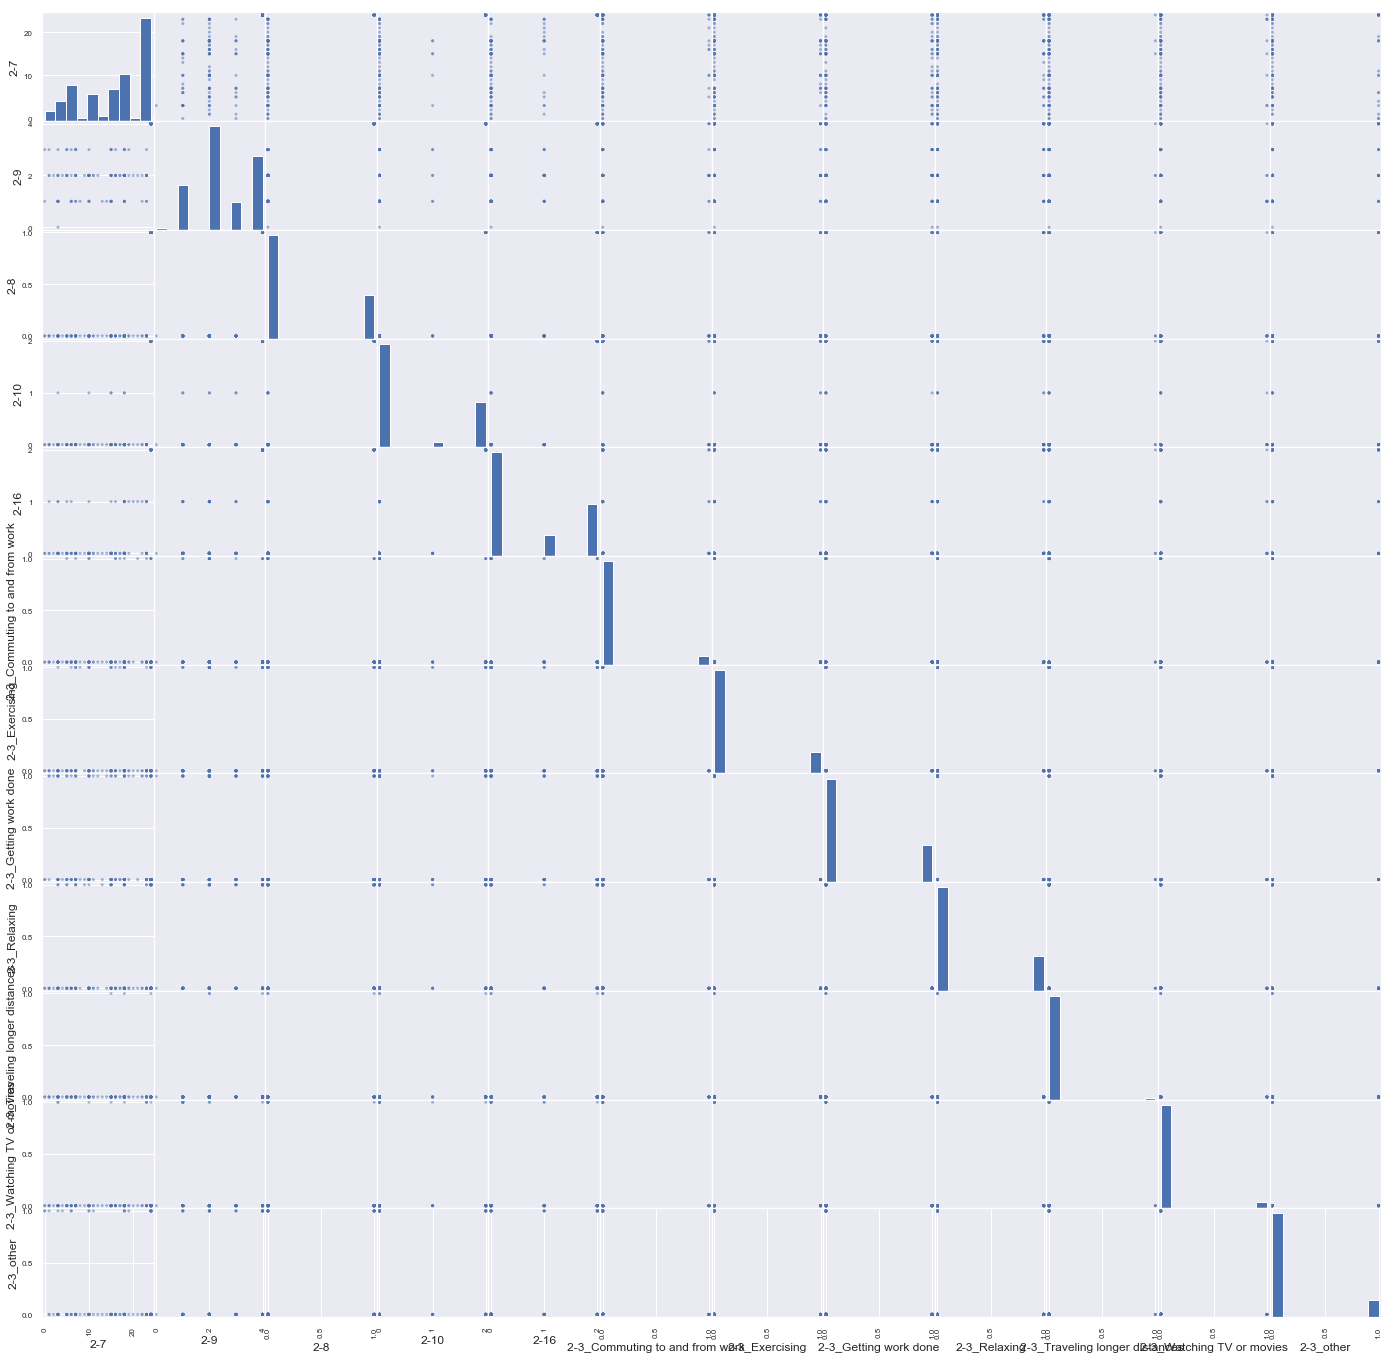

In [7]:
eda.correlation_matrix_plots()

In [8]:
eda.correlation_matrix()

question_name,2-7,2-9,2-8,2-10,2-16,2-3_Commuting to and from work,2-3_Exercising,2-3_Getting work done,2-3_Relaxing,2-3_Traveling longer distances,2-3_Watching TV or movies,2-3_other
question_name,,,,,,,,,,,,
2-7,1.000000,0.625361,0.695410,0.685495,0.697617,0.029927,-0.003048,-0.136277,0.152035,0.056976,0.001129,-0.030385
2-9,0.625361,1.000000,0.867485,0.853436,0.813290,-0.033039,-0.026001,-0.084636,0.158784,0.018748,-0.204154,0.102478
2-8,0.695410,0.867485,1.000000,0.979417,0.936382,-0.040007,-0.052492,-0.123935,0.158975,0.011535,-0.094962,0.109047
2-10,0.685495,0.853436,0.979417,1.000000,0.909840,-0.051383,-0.035897,-0.133143,0.166891,0.006373,-0.075632,0.093767
2-16,0.697617,0.813290,0.936382,0.909840,1.000000,-0.029191,-0.060839,-0.116051,0.115996,-0.005892,-0.069289,0.133670
2-3_Commuting to and from work,0.029927,-0.033039,-0.040007,-0.051383,-0.029191,1.000000,-0.130500,-0.172653,-0.167438,-0.038568,-0.068035,-0.116668
2-3_Exercising,-0.003048,-0.026001,-0.052492,-0.035897,-0.060839,-0.130500,1.000000,-0.272108,-0.263889,-0.060784,-0.107225,-0.183873
2-3_Getting work done,-0.136277,-0.084636,-0.123935,-0.133143,-0.116051,-0.172653,-0.272108,1.000000,-0.349127,-0.080418,-0.141860,-0.243265
2-3_Relaxing,0.152035,0.158784,0.158975,0.166891,0.115996,-0.167438,-0.263889,-0.349127,1.000000,-0.077989,-0.137575,-0.235918


# Relative Variance

In [9]:
explained_variances = eda.pca_explained_variances()
for i, q_id in enumerate(fd.independent_variables):
    print(q_id, round(explained_variances[i],2))

2-7 0.96
2-9 0.02
2-8 0.0
2-10 0.0
2-16 0.0
2-3_Commuting to and from work 0.0
2-3_Exercising 0.0
2-3_Getting work done 0.0
2-3_Relaxing 0.0
2-3_Traveling longer distances 0.0
2-3_Watching TV or movies 0.0
2-3_other 0.0


# Single Value Decomposition
## Data Projected onto a 2D space, and colored by Outcome

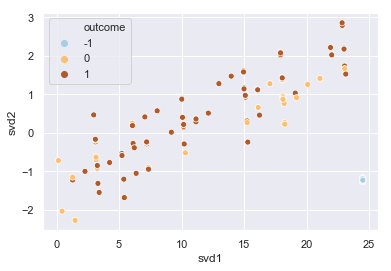

In [10]:
eda.plot_outcome_clusters()

# Logistic Regression
## Histogram of Predicted Probability of Positive Outcome, colored by Actual Outcome


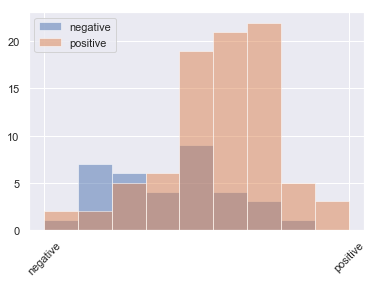

In [11]:
logistic_regression.visualize_goodness()

#
## Results Summary

In [12]:
logistic_regression.print_results()

    Variable                          Coefficienct    Standard Error       z    p-Value    lower    upper
--  ------------------------------  --------------  ----------------  ------  ---------  -------  -------
 0  2-7                                     -0.089             0.365  -0.244      0.807   -0.687    0.509
 1  2-9                                     -0.833             0.518  -1.608      0.108   -1.683    0.017
 2  2-8                                     -0.226             1.167  -0.194      0.846   -2.141    1.688
 3  2-10                                    -1.387             0.996  -1.393      0.164   -3.021    0.246
 4  2-16                                    -1.279             0.615  -2.08       0.037   -2.287   -0.271
 5  2-3_Commuting to and from work           0.105             0.501   0.211      0.833   -0.716    0.927
 6  2-3_Exercising                           0.64              0.713   0.898      0.369   -0.529    1.81
 7  2-3_Getting work done                    0.

# 
## Simulated Probability of Positive Outcome controlling for all but one variable

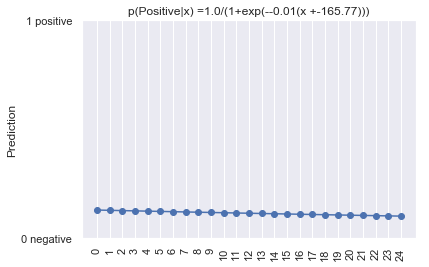

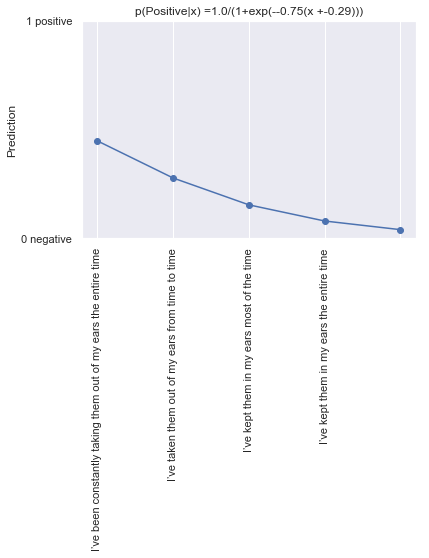

In [13]:
for independent_variable in fd.continuous_independent_variables:
    if independent_variable not in fd.binary_independent_variables:
        logistic_regression.simulate_continuous_outcomes(independent_variable)

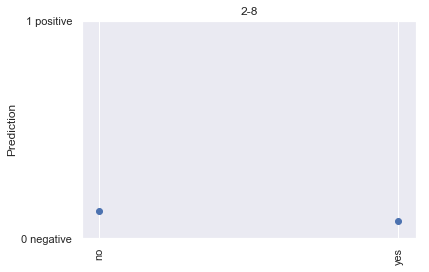

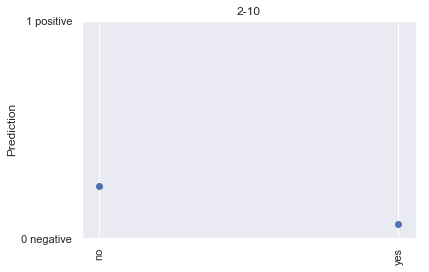

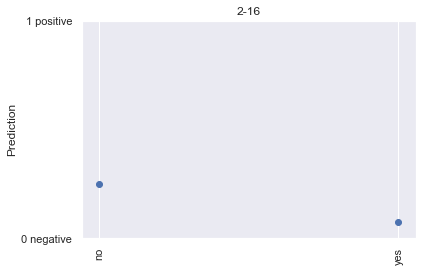

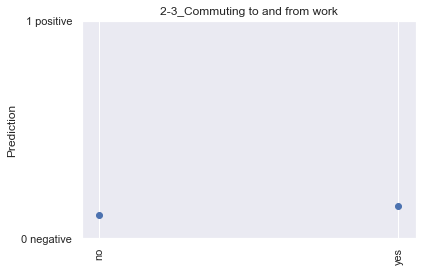

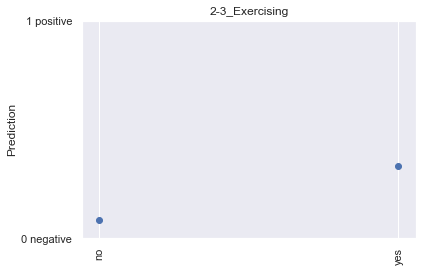

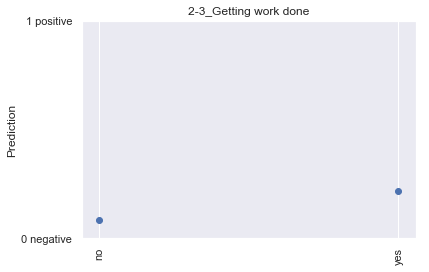

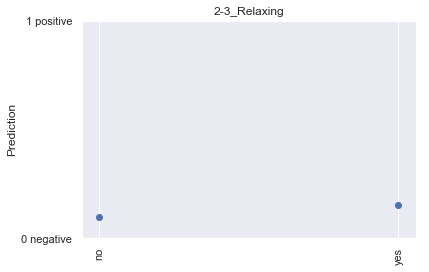

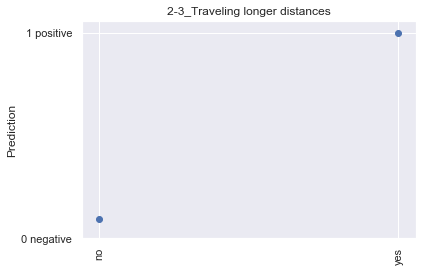

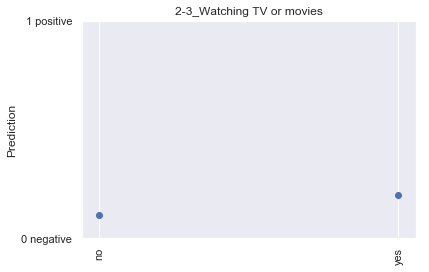

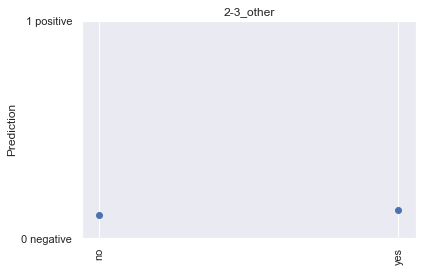

In [14]:
for independent_variable in fd.independent_variables:
    if independent_variable in fd.binary_independent_variables or\
       independent_variable in fd.dummies:
        logistic_regression.simulate_binary_outcomes(independent_variable)